# Baseline vs Recurrent Transformer Comparison

This notebook compares two transformer architectures:
1. **Baseline Transformer**: Standard multi-layer architecture
2. **Recurrent Transformer**: Iterates through fewer layers multiple times

Key comparisons:
- Model size and parameter efficiency
- Training dynamics and convergence
- Inference speed vs accuracy trade-offs
- Hyperparameter sensitivity analysis


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Model configurations
BASELINE_CONFIG = {
    'hidden_size': 384,
    'num_hidden_layers': 6,
    'num_attention_heads': 6,
    'intermediate_size': 1536,
    'dropout_prob': 0.1,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

RECURRENT_CONFIG = {
    'hidden_size': 256,
    'num_hidden_layers': 3,
    'recurrent_depth': 2,  # Effective depth: 3 × 2 = 6
    'num_attention_heads': 4,
    'intermediate_size': 1024,
    'dropout_prob': 0.1,
    'residual_scale': 0.5,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

TRAINING_CONFIG = {
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 3e-5,
    'warmup_steps': 100,
    'eval_steps': 50,
    'max_length': 128
}


In [ ]:
# Load data
from training.utils import prepare_sst2_data, load_tokenizer

tokenizer = load_tokenizer('bert-base-uncased')
train_loader, val_loader, test_loader = prepare_sst2_data(
    data_dir='data/processed',
    tokenizer=tokenizer,
    batch_size=TRAINING_CONFIG['batch_size'],
    max_length=TRAINING_CONFIG['max_length']
)

train_size = len(train_loader) * TRAINING_CONFIG['batch_size']
val_size = len(val_loader) * TRAINING_CONFIG['batch_size']
print(f"Dataset sizes - Train: {train_size}, Validation: {val_size}")


Loaded 54576 samples from data/processed\sst2_train.pkl
Loaded 6822 samples from data/processed\sst2_val.pkl
Loaded 6823 samples from data/processed\sst2_test.pkl
Dataset sizes - Train: 54576, Validation: 6832


In [ ]:
# Initialize models
from models.baseline import BaselineModel, BaselineConfig
from models.recurrent import RecurrentModel, RecurrentConfig

# Baseline model
baseline_config = BaselineConfig(
    vocab_size=30522,
    hidden_size=BASELINE_CONFIG['hidden_size'],
    num_hidden_layers=BASELINE_CONFIG['num_hidden_layers'],
    num_attention_heads=BASELINE_CONFIG['num_attention_heads'],
    intermediate_size=BASELINE_CONFIG['intermediate_size'],
    hidden_dropout_prob=BASELINE_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=BASELINE_CONFIG['dropout_prob'],
    num_labels=2,
    **{k: v for k, v in BASELINE_CONFIG.items() if k.startswith('use_')}
)

# Recurrent model
recurrent_config = RecurrentConfig(
    vocab_size=30522,
    hidden_size=RECURRENT_CONFIG['hidden_size'],
    num_hidden_layers=RECURRENT_CONFIG['num_hidden_layers'],
    recurrent_depth=RECURRENT_CONFIG['recurrent_depth'],
    num_attention_heads=RECURRENT_CONFIG['num_attention_heads'],
    intermediate_size=RECURRENT_CONFIG['intermediate_size'],
    hidden_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    attention_probs_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
    residual_scale=RECURRENT_CONFIG['residual_scale'],
    num_labels=2,
    **{k: v for k, v in RECURRENT_CONFIG.items() if k.startswith('use_')}
)

baseline_model = BaselineModel(baseline_config).to(device)
recurrent_model = RecurrentModel(recurrent_config).to(device)

# Model statistics
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

baseline_params = count_parameters(baseline_model)
recurrent_params = count_parameters(recurrent_model)

print(f"Baseline: {baseline_params:,} parameters ({baseline_params/1e6:.1f}M)")
print(f"Recurrent: {recurrent_params:,} parameters ({recurrent_params/1e6:.1f}M)")
print(f"Parameter reduction: {(1 - recurrent_params/baseline_params)*100:.1f}%")


Baseline: 25,912,706 parameters (25.9M)
Recurrent: 10,972,162 parameters (11.0M)
Parameter reduction: 57.7%


In [ ]:
# Train both models using centralized training function
from training import train_model

print("Training with early stopping (patience=3)")
print("-" * 50)

# Train baseline model
baseline_history = train_model(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    name="Baseline",
    num_epochs=TRAINING_CONFIG['num_epochs'],
    learning_rate=TRAINING_CONFIG['learning_rate'],
    patience=3,
    save_dir='../checkpoints'
)

print()

# Train recurrent model
recurrent_history = train_model(
    model=recurrent_model,
    train_loader=train_loader,
    val_loader=val_loader,
    name="Recurrent",
    num_epochs=TRAINING_CONFIG['num_epochs'],
    learning_rate=TRAINING_CONFIG['learning_rate'],
    patience=3,
    save_dir='../checkpoints'
)


Training Baseline Model


Baseline Epoch 1: Train Loss=0.3969, Val Loss=0.2883, Val Acc=0.8851


Baseline Epoch 2: Train Loss=0.2324, Val Loss=0.2637, Val Acc=0.8982


Baseline Epoch 3: Train Loss=0.1849, Val Loss=0.2586, Val Acc=0.9041


Baseline Epoch 4: Train Loss=0.1537, Val Loss=0.3024, Val Acc=0.9088


Baseline Epoch 5: Train Loss=0.1270, Val Loss=0.3165, Val Acc=0.9151

Training Recurrent Model


Recurrent Epoch 1: Train Loss=0.4107, Val Loss=0.2961, Val Acc=0.8833


Recurrent Epoch 2: Train Loss=0.2389, Val Loss=0.2699, Val Acc=0.8976


Recurrent Epoch 3: Train Loss=0.1947, Val Loss=0.2777, Val Acc=0.9035


Recurrent Epoch 4: Train Loss=0.1689, Val Loss=0.2814, Val Acc=0.9062


Recurrent Epoch 5: Train Loss=0.1482, Val Loss=0.3213, Val Acc=0.9053


In [ ]:
# Evaluate models
def evaluate_model(model, loader):
    model.eval()
    
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    inference_times = []
    
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Measure inference time
            start_time = time.time()
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            inference_times.append((time.time() - start_time) * 1000 / batch['input_ids'].size(0))
            
            predictions = outputs['logits'].argmax(dim=-1)
            total_correct += (predictions == batch['labels']).sum().item()
            total_samples += batch['labels'].size(0)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    
    accuracy = total_correct / total_samples
    avg_inference_time = np.mean(inference_times)
    
    # Calculate F1 score
    from sklearn.metrics import f1_score, precision_score, recall_score
    f1 = f1_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'inference_time_ms': avg_inference_time
    }

# Evaluate on test set
baseline_metrics = evaluate_model(baseline_model, test_loader)
recurrent_metrics = evaluate_model(recurrent_model, test_loader)

# Model sizes
baseline_size_mb = baseline_params * 4 / (1024 * 1024)  # 4 bytes per parameter
recurrent_size_mb = recurrent_params * 4 / (1024 * 1024)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Recurrent'],
    'Parameters': [baseline_params, recurrent_params],
    'Size (MB)': [baseline_size_mb, recurrent_size_mb],
    'Accuracy': [baseline_metrics['accuracy'], recurrent_metrics['accuracy']],
    'F1': [baseline_metrics['f1'], recurrent_metrics['f1']],
    'Precision': [baseline_metrics['precision'], recurrent_metrics['precision']],
    'Recall': [baseline_metrics['recall'], recurrent_metrics['recall']],
    'Inference (ms)': [baseline_metrics['inference_time_ms'], recurrent_metrics['inference_time_ms']]
})

print(comparison_df.round(4))


       Model  Parameters  Size (MB)  Accuracy      F1  Precision  Recall  \
0   Baseline    25912706    98.8491    0.7901  0.7946     0.7919  0.7973   
1  Recurrent    10972162    41.8555    0.7993  0.8031     0.8022  0.8041   

   Inference (ms)  
0          0.1659  
1          0.1795  


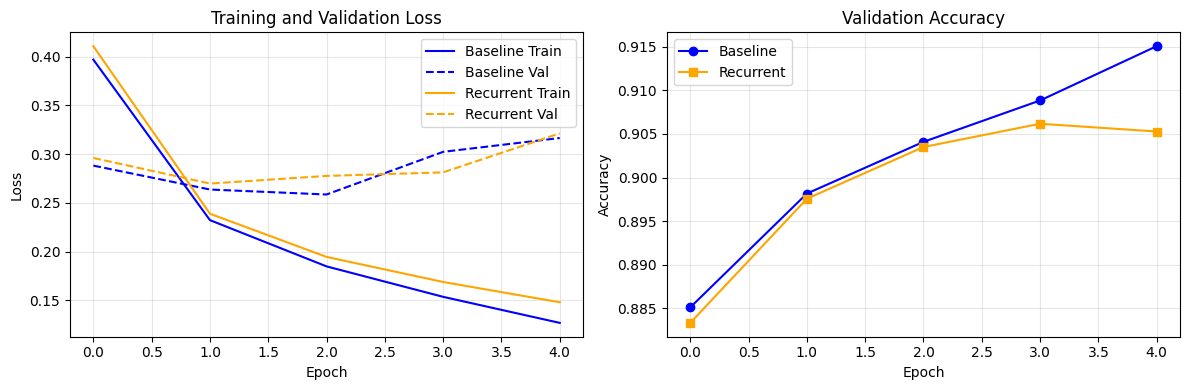

In [ ]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(baseline_history['train_loss'], label='Baseline Train', color='blue', linestyle='-')
axes[0].plot(baseline_history['val_loss'], label='Baseline Val', color='blue', linestyle='--')
axes[0].plot(recurrent_history['train_loss'], label='Recurrent Train', color='orange', linestyle='-')
axes[0].plot(recurrent_history['val_loss'], label='Recurrent Val', color='orange', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(baseline_history['val_acc'], label='Baseline', color='blue', marker='o')
axes[1].plot(recurrent_history['val_acc'], label='Recurrent', color='orange', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


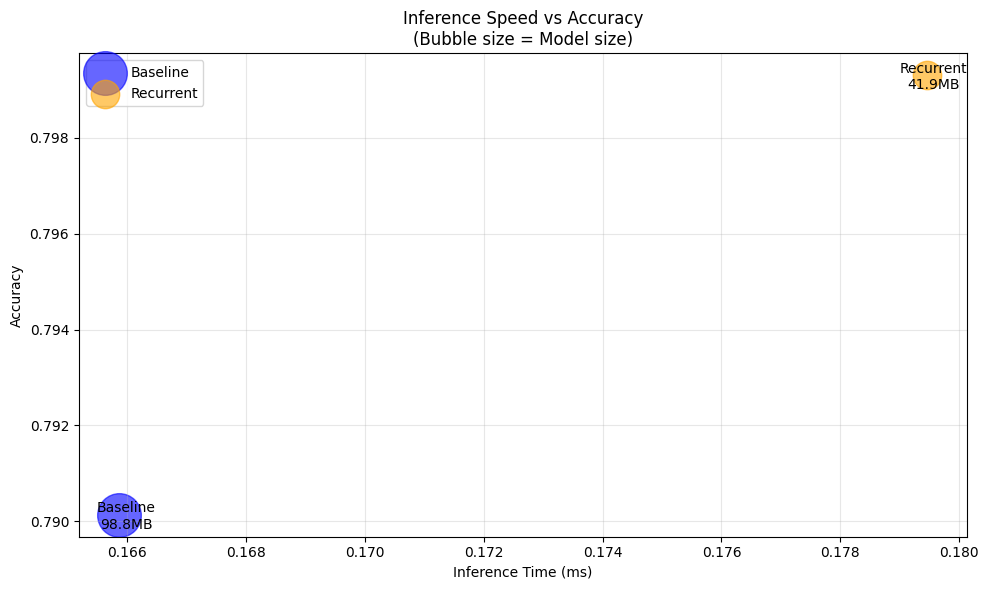

In [ ]:
# Bubble plot: Inference Time vs Accuracy
plt.figure(figsize=(10, 6))

# Create bubble sizes based on model size
bubble_sizes = [
    baseline_size_mb * 10,
    recurrent_size_mb * 10
]

# Plot bubbles
plt.scatter([baseline_metrics['inference_time_ms']], [baseline_metrics['accuracy']], 
           s=bubble_sizes[0], alpha=0.6, color='blue', label='Baseline')
plt.scatter([recurrent_metrics['inference_time_ms']], [recurrent_metrics['accuracy']], 
           s=bubble_sizes[1], alpha=0.6, color='orange', label='Recurrent')

# Add annotations
plt.annotate(f'Baseline\n{baseline_size_mb:.1f}MB', 
            xy=(baseline_metrics['inference_time_ms'], baseline_metrics['accuracy']),
            xytext=(5, -10), textcoords='offset points', ha='center')
plt.annotate(f'Recurrent\n{recurrent_size_mb:.1f}MB', 
            xy=(recurrent_metrics['inference_time_ms'], recurrent_metrics['accuracy']),
            xytext=(5, -10), textcoords='offset points', ha='center')

plt.xlabel('Inference Time (ms)')
plt.ylabel('Accuracy')
plt.title('Inference Speed vs Accuracy\n(Bubble size = Model size)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
